In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

# Add project root to path
sys.path.append(os.path.abspath(".."))

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

pd.set_option('display.max_columns', None)

## 1. Load Data

In [2]:
import src.features
import importlib
importlib.reload(src.features)
# We use aggregate_user_features directly to control the snapshots
from src.features import extract_user_attributes, aggregate_user_features

print("Regenerating Training Features from Raw Data (Robust Sliding Window)...")
train_raw_path = '../data/train.parquet'
train_df_raw = pd.read_parquet(train_raw_path)
train_df_raw = extract_user_attributes(train_df_raw)

# --- ROBUST DATA GENERATION ---
# We generate multiple training samples per user at different points in time.
# This ensures the model sees a realistic distribution of 'days_since_last_session'.

CHURN_WINDOW_DAYS = 10  # Prediction window (e.g., will they CANCEL in next 10 days?)
SNAPSHOT_INTERVAL_DAYS = 14 # How often to take a snapshot
N_SNAPSHOTS = 3 # Reverted to 3 to reduce class imbalance (6 was too aggressive)

max_ts = train_df_raw['ts'].max()
dfs = []

for i in range(N_SNAPSHOTS):
    # Move back in time to create a "virtual" prediction point
    # We start at least CHURN_WINDOW_DAYS back so we have ground truth labels
    cutoff_ts = max_ts - pd.Timedelta(days=CHURN_WINDOW_DAYS + (i * SNAPSHOT_INTERVAL_DAYS))
    
    print(f"Generating snapshot {i+1}/{N_SNAPSHOTS} at {cutoff_ts}...")
    
    # 1. Identify users active *before* this cutoff
    active_users = train_df_raw[train_df_raw['ts'] <= cutoff_ts]['userId'].unique()
    
    snapshot_df = pd.DataFrame({
        'userId': active_users,
        'cutoff_ts': cutoff_ts
    })
    
    # 2. Generate Features relative to this cutoff
    # This ensures 'days_since_last_session' is calculated correctly (Cutoff - Last Event)
    features = aggregate_user_features(train_df_raw, snapshot_df=snapshot_df)
    features = features.reset_index(level='cutoff_ts', drop=True)
    
    # 3. Generate Target (CORRECTED DEFINITION)
    # Target = 1 ONLY if "Cancellation Confirmation" event occurs in [cutoff_ts, cutoff_ts + window]
    future_start = cutoff_ts
    future_end = cutoff_ts + pd.Timedelta(days=CHURN_WINDOW_DAYS)
    
    # Find users who explicitly cancelled in the window
    churners = train_df_raw[
        (train_df_raw['ts'] > future_start) & 
        (train_df_raw['ts'] <= future_end) &
        (train_df_raw['page'] == 'Cancellation Confirmation')
    ]['userId'].unique()
    
    features['target'] = 0 # Default to Non-Churn
    features.loc[features.index.isin(churners), 'target'] = 1
    
    # FIX: Ensure userId is a column for GroupShuffleSplit later
    if 'userId' not in features.columns:
        features = features.reset_index()
    
    dfs.append(features)

df = pd.concat(dfs)

# --- FEATURE ENGINEERING BOOST ---
# Add ratio features to capture trends (Velocity)
if 'sessions_last_7d' in df.columns and 'sessions_last_28d' in df.columns:
    # Avoid division by zero
    df['session_velocity'] = df['sessions_last_7d'] / (df['sessions_last_28d'] / 4 + 0.01)

# Interaction: Recency vs Frequency
if 'days_since_last_session' in df.columns and 'total_sessions' in df.columns:
    df['recency_frequency_ratio'] = df['days_since_last_session'] / (df['total_sessions'] + 1)

print(f"Dataset Shape: {df.shape}")
print(f"Churn Rate: {df['target'].mean():.2%}")

print("\nAvg Gap for Non-Churners (Target 0) - Should NOT be 0:")
print(df[df['target']==0]['days_since_last_session'].describe())

df.head()

Regenerating Training Features from Raw Data (Robust Sliding Window)...
Generating snapshot 1/3 at 2018-11-10 00:00:00...
Generating snapshot 1/3 at 2018-11-10 00:00:00...
Generating snapshot 2/3 at 2018-10-27 00:00:00...
Generating snapshot 2/3 at 2018-10-27 00:00:00...
Generating snapshot 3/3 at 2018-10-13 00:00:00...
Generating snapshot 3/3 at 2018-10-13 00:00:00...
Dataset Shape: (52942, 64)
Churn Rate: 4.06%

Avg Gap for Non-Churners (Target 0) - Should NOT be 0:
count    50795.000000
mean         6.566054
std          8.172790
min          0.000000
25%          1.016319
50%          3.211296
75%          9.062483
max         39.995347
Name: days_since_last_session, dtype: float64
Dataset Shape: (52942, 64)
Churn Rate: 4.06%

Avg Gap for Non-Churners (Target 0) - Should NOT be 0:
count    50795.000000
mean         6.566054
std          8.172790
min          0.000000
25%          1.016319
50%          3.211296
75%          9.062483
max         39.995347
Name: days_since_last_sessio

,userId,gender,level,platform,is_thumbs_up,is_thumbs_down,is_ad,is_error,is_song,length,downgrade,songs_last_1d,errors_last_1d,thumbs_down_last_1d,listen_time_last_1d,unique_artists_last_1d,unique_songs_last_1d,songs_last_3d,errors_last_3d,thumbs_down_last_3d,listen_time_last_3d,unique_artists_last_3d,unique_songs_last_3d,songs_last_7d,errors_last_7d,thumbs_down_last_7d,listen_time_last_7d,unique_artists_last_7d,unique_songs_last_7d,songs_last_14d,errors_last_14d,thumbs_down_last_14d,listen_time_last_14d,unique_artists_last_14d,unique_songs_last_14d,songs_last_30d,errors_last_30d,thumbs_down_last_30d,listen_time_last_30d,unique_artists_last_30d,unique_songs_last_30d,account_lifetime,avg_songs_per_day,thumbs_ratio,errors_per_song,trend_songs_7d_vs_30d,trend_listen_time_7d_vs_30d,total_sessions,avg_days_between_sessions,days_since_last_session,avg_songs_per_session,avg_session_duration,last_session_errors,last_session_songs,last_session_length,last_session_downgrade,activity_trend,boredom_ratio,exploration_ratio,hate_ratio_7d,recency_frequency_ratio,session_velocity,state_freq,target
0,1000025,M,paid,Windows,94,13,7,1,1662,417296.59169,0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,753.0,1.0,3.0,191705.85933,597.0,702.0,122.604074,13.446159,0.870370,0.000601,0.000000,0.000000,17,7.212004,22.143692,97.764706,24546.858335,0,96,25141.06340,0,-25.100000,1.024165,0.000000,0.000000,1.230205,0.000000,0.012341,0
1,1000035,F,paid,Linux,75,11,5,0,861,210659.31890,0,0.0,0.0,0.0,0.00000,0.0,0.0,116.0,0.0,2.0,27695.98656,108.0,116.0,116.0,0.0,2.0,27695.98656,108.0,116.0,338.0,0.0,5.0,81898.00841,299.0,330.0,858.0,0.0,11.0,210033.68761,663.0,804.0,58.188634,14.546712,0.862069,0.000000,0.540541,0.527457,16,3.636790,1.839028,53.812500,13166.207431,0,116,27695.98656,0,-12.028571,2.103406,0.651191,0.017094,0.108178,0.540767,0.010964,0
2,1000083,M,paid,Windows,21,2,8,0,501,122606.27093,0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,213.0,0.0,2.0,52170.90103,203.0,211.0,63.248738,7.797818,0.875000,0.000000,0.000000,0.000000,11,5.749885,28.579884,45.545455,11146.024630,0,133,32234.91114,0,-7.100000,2.891795,0.000000,0.000000,2.381657,0.000000,0.007574,0
3,1000103,F,paid,Linux,2,1,3,0,57,13554.73009,0,0.0,0.0,0.0,0.00000,0.0,0.0,5.0,0.0,0.0,984.08263,5.0,5.0,5.0,0.0,0.0,984.08263,5.0,5.0,5.0,0.0,0.0,984.08263,5.0,5.0,18.0,0.0,0.0,3785.68327,18.0,18.0,48.689294,1.147128,0.500000,0.000000,1.086957,1.039684,3,16.229765,1.230093,19.000000,4518.243363,0,5,984.08263,0,0.114286,0.217754,1.086957,0.000000,0.307523,1.108647,0.031727,0
4,1000164,F,paid,Windows,18,4,20,1,534,133275.57835,0,166.0,1.0,2.0,41422.37044,149.0,160.0,166.0,1.0,2.0,41422.37044,149.0,160.0,166.0,1.0,2.0,41422.37044,149.0,160.0,200.0,1.0,2.0,50223.79174,178.0,191.0,480.0,1.0,4.0,120494.59380,397.0,451.0,89.602766,5.893860,0.782609,0.001869,1.382182,1.375074,11,8.145706,0.497500,48.545455,12115.961668,1,166,41422.37044,0,7.714286,3.418544,1.499748,0.011976,0.041458,1.383218,0.020869,0


## 2. Preprocessing & Splitting

We will use a **Stratified Split** to maintain the churn ratio in both training and test sets.
We will also define a `ColumnTransformer` to handle:
- **Numerical Features**: Standard Scaling.
- **Categorical Features**: One-Hot Encoding.

In [3]:
from sklearn.model_selection import GroupShuffleSplit
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

cols_to_drop = ["target", "userId", "cutoff_ts"]
X = df.drop(columns=[c for c in cols_to_drop if c in df.columns])
y = df['target']

categorical_cols = ['gender', 'level', 'platform']
numerical_cols = [c for c in X.columns if c not in categorical_cols]  # type: ignore

print(f"Categorical Columns ({len(categorical_cols)}): {categorical_cols}")
print(f"Numerical Columns ({len(numerical_cols)}): {numerical_cols[:5]} ...")

# GroupShuffleSplit to ensure no user appears in both train and test (prevent leakage)
splitter = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=RANDOM_SEED)
train_idx, test_idx = next(splitter.split(X, y, groups=df['userId']))

X_train = X.iloc[train_idx]
X_test = X.iloc[test_idx]
y_train = y.iloc[train_idx]
y_test = y.iloc[test_idx]

print(f"\nTraining Shape: {X_train.shape}")
print(f"Test Shape: {X_test.shape}")
print(f"Train Churn Rate: {y_train.mean():.2%}")
print(f"Test Churn Rate: {y_test.mean():.2%}")

Categorical Columns (3): ['gender', 'level', 'platform']
Numerical Columns (59): ['is_thumbs_up', 'is_thumbs_down', 'is_ad', 'is_error', 'is_song'] ...

Training Shape: (42330, 62)
Test Shape: (10612, 62)
Train Churn Rate: 4.04%
Test Churn Rate: 4.11%


In [4]:
# --- FEATURE SELECTION ---
# We use a fast LightGBM model to identify and drop noisy features.
# This helps the Stacking model focus on the signal.

from lightgbm import LGBMClassifier

print("--- Performing Feature Selection ---")

# Prepare data for LightGBM (needs 'category' dtype for cats)
X_sel = X_train.copy()
for c in categorical_cols:
    X_sel[c] = X_sel[c].astype('category')

# Fit fast LGBM
lgbm_sel = LGBMClassifier(n_estimators=100, random_state=RANDOM_SEED, verbose=-1)
lgbm_sel.fit(X_sel, y_train)

# Get Importances
importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': lgbm_sel.feature_importances_
}).sort_values(by='importance', ascending=False)

# Drop bottom 20% (or features with 0 importance)
zero_imp_features = importances[importances['importance'] == 0]['feature'].tolist()
cutoff_idx = int(len(importances) * 0.8) # Keep top 80%
low_imp_features = importances.iloc[cutoff_idx:]['feature'].tolist()

features_to_drop = list(set(zero_imp_features + low_imp_features))
print(f"Dropping {len(features_to_drop)} features (Bottom 20% + Zero Importance):")
print(features_to_drop)

# Update X_train and X_test
X_train = X_train.drop(columns=features_to_drop)
X_test = X_test.drop(columns=features_to_drop)

# Update column lists
numerical_cols = [c for c in numerical_cols if c not in features_to_drop]
categorical_cols = [c for c in categorical_cols if c not in features_to_drop]

print(f"New Feature Count: {X_train.shape[1]}")
print(f"Top 5 Features: {importances.head(5)['feature'].tolist()}")

--- Performing Feature Selection ---
Dropping 13 features (Bottom 20% + Zero Importance):
['errors_last_7d', 'unique_songs_last_3d', 'thumbs_down_last_1d', 'last_session_downgrade', 'unique_songs_last_1d', 'is_error', 'errors_last_1d', 'errors_last_3d', 'last_session_errors', 'errors_last_14d', 'session_velocity', 'downgrade', 'errors_last_30d']
New Feature Count: 49
Top 5 Features: ['thumbs_ratio', 'state_freq', 'days_since_last_session', 'is_ad', 'account_lifetime']
Dropping 13 features (Bottom 20% + Zero Importance):
['errors_last_7d', 'unique_songs_last_3d', 'thumbs_down_last_1d', 'last_session_downgrade', 'unique_songs_last_1d', 'is_error', 'errors_last_1d', 'errors_last_3d', 'last_session_errors', 'errors_last_14d', 'session_velocity', 'downgrade', 'errors_last_30d']
New Feature Count: 49
Top 5 Features: ['thumbs_ratio', 'state_freq', 'days_since_last_session', 'is_ad', 'account_lifetime']


In [5]:
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, numerical_cols),
        ('cat', cat_transformer, categorical_cols)
    ]
)

X_train_processed = preprocessor.fit_transform(X_train)
print(f"Processed Feature Matrix Shape: {X_train_processed.shape}")

Processed Feature Matrix Shape: (42330, 53)


## 3. Baseline Model Evaluation

We will evaluate the following industry-standard models:
1.  **Logistic Regression**: Simple baseline for interpretability.
2.  **Random Forest**: Robust bagging ensemble.
3.  **XGBoost**: Gradient boosting (often SOTA for tabular data).
4.  **LightGBM**: Faster and often more accurate gradient boosting.
5.  **CatBoost**: Excellent for categorical features (though we OHE them here).

**Metrics**:
- **F1-Score**: Harmonic mean of precision and recall (crucial for imbalanced churn).
- **ROC-AUC**: Ability to distinguish between classes.

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_validate
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# Calculate class weight ratio for XGBoost
# We need to help the model see the needle in the haystack
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos
print(f"Class Imbalance Ratio: 1:{scale_pos_weight:.2f}")
print("Applying Class Weights to all models to fix F1 Score...")

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced', random_state=RANDOM_SEED),
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=RANDOM_SEED),
    "XGBoost": XGBClassifier(eval_metric='logloss', scale_pos_weight=scale_pos_weight, random_state=RANDOM_SEED),
    "LightGBM": LGBMClassifier(random_state=RANDOM_SEED, class_weight='balanced', verbose=-1),
    "CatBoost": CatBoostClassifier(verbose=0, auto_class_weights='Balanced', random_state=RANDOM_SEED)
}

def evaluate_models(models, X, y, preprocessor):
    results = []
    for name, model in models.items():
        clf = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', model)])
        
        # Cross-validation (5-fold)
        cv_results = cross_validate(clf, X, y, cv=5, scoring=['f1', 'roc_auc', 'accuracy'])
        
        results.append({
            "Model": name,
            "F1 Score (Mean)": cv_results['test_f1'].mean(),
            "F1 Score (Std)": cv_results['test_f1'].std(),
            "ROC-AUC (Mean)": cv_results['test_roc_auc'].mean(),
            "ROC-AUC (Std)": cv_results['test_roc_auc'].std(),
            "Accuracy (Mean)": cv_results['test_accuracy'].mean(),
            "Accuracy (Std)": cv_results['test_accuracy'].std(),
        })
        print(f"Evaluated {name}...")
        
    return pd.DataFrame(results).sort_values(by="F1 Score (Mean)", ascending=False)

results_df = evaluate_models(models, X_train, y_train, preprocessor)
results_df

Class Imbalance Ratio: 1:23.74
Applying Class Weights to all models to fix F1 Score...
Evaluated Logistic Regression...
Evaluated Logistic Regression...
Evaluated Random Forest...
Evaluated Random Forest...
Evaluated XGBoost...
Evaluated XGBoost...
Evaluated LightGBM...
Evaluated LightGBM...
Evaluated CatBoost...
Evaluated CatBoost...


,Model,F1 Score (Mean),F1 Score (Std),ROC-AUC (Mean),ROC-AUC (Std),Accuracy (Mean),Accuracy (Std)
3,LightGBM,0.157428,0.018517,0.709561,0.029730,0.819584,0.017757
0,Logistic Regression,0.144493,0.009804,0.727813,0.022792,0.692251,0.017135
4,CatBoost,0.143192,0.015843,0.682480,0.031536,0.892157,0.009170
2,XGBoost,0.116327,0.021952,0.648066,0.030512,0.902504,0.004956
1,Random Forest,0.002332,0.002857,0.676056,0.020997,0.959627,0.000088


## 4. Hyperparameter Tuning

We will now optimize the hyperparameters for our top two performing models: **XGBoost** and **CatBoost**.
We use `RandomizedSearchCV` which is more efficient than Grid Search as it samples a fixed number of parameter settings from specified distributions.


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier

def tune_model(model, params, X, y, preprocessor, n_iter=20):
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', model)])
    
    search = RandomizedSearchCV(
        pipeline, 
        param_distributions=params, 
        n_iter=n_iter, 
        scoring='f1', 
        cv=3, 
        verbose=1, 
        random_state=RANDOM_SEED, 
        n_jobs=-1
    )
    
    search.fit(X, y)
    return search

In [ ]:
import optuna
from sklearn.model_selection import cross_val_score

# Define Optuna Objective for XGBoost
def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 0.5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'eval_metric': 'logloss',
        'random_state': RANDOM_SEED,
        'n_jobs': 1,
        'verbosity': 0
    }
    
    model = XGBClassifier(**params)
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', model)])
    
    scores = cross_val_score(pipeline, X_train, y_train, cv=3, scoring='f1')
    return scores.mean()

print("--- Tuning XGBoost with Optuna ---")
optuna.logging.set_verbosity(optuna.logging.WARNING)
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=30, show_progress_bar=True)

print(f"Best XGBoost F1: {study_xgb.best_value:.4f}")
print(f"Best XGBoost Params: {study_xgb.best_params}")

# Create best model
best_xgb_params = study_xgb.best_params
best_xgb_params['eval_metric'] = 'logloss'
best_xgb_params['random_state'] = RANDOM_SEED
best_xgb_params['n_jobs'] = 1
best_xgb = XGBClassifier(**best_xgb_params)

In [ ]:
# Define Optuna Objective for LightGBM
def objective_lgbm(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'random_state': RANDOM_SEED,
        'n_jobs': 1,
        'verbose': -1
    }
    
    model = LGBMClassifier(**params)
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', model)])
    
    # Suppress warnings specifically for LightGBM
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message=".*X does not have valid feature names.*")
        scores = cross_val_score(pipeline, X_train, y_train, cv=3, scoring='f1')
    return scores.mean()

print("\n--- Tuning LightGBM with Optuna ---")
study_lgbm = optuna.create_study(direction='maximize')
study_lgbm.optimize(objective_lgbm, n_trials=30, show_progress_bar=True)

print(f"Best LightGBM F1: {study_lgbm.best_value:.4f}")
print(f"Best LightGBM Params: {study_lgbm.best_params}")

# Recreate best model
best_lgbm_params = study_lgbm.best_params
best_lgbm_params['random_state'] = RANDOM_SEED
best_lgbm_params['n_jobs'] = 1
best_lgbm_params['verbose'] = -1
best_lgbm = LGBMClassifier(**best_lgbm_params)

In [ ]:
# Define Optuna Objective for CatBoost
def objective_cat(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 200, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'random_strength': trial.suggest_float('random_strength', 1e-9, 10, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
        'verbose': 0,
        'random_state': RANDOM_SEED,
        'thread_count': -1
    }
    
    model = CatBoostClassifier(**params)
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', model)])
    
    scores = cross_val_score(pipeline, X_train, y_train, cv=3, scoring='f1')
    return scores.mean()

print("\n--- Tuning CatBoost with Optuna ---")
study_cat = optuna.create_study(direction='maximize')
study_cat.optimize(objective_cat, n_trials=30, show_progress_bar=True)

print(f"Best CatBoost F1: {study_cat.best_value:.4f}")
print(f"Best CatBoost Params: {study_cat.best_params}")

# Recreate best model
best_cat_params = study_cat.best_params
best_cat_params['verbose'] = 0
best_cat_params['random_state'] = RANDOM_SEED
best_cat_params['thread_count'] = 1
best_cat = CatBoostClassifier(**best_cat_params)

## 5. Ensemble Modeling (Stacking)

We will now combine our tuned **XGBoost** and **CatBoost** models using a `StackingClassifier`.
This technique uses a meta-model (Logistic Regression) to learn the best combination of the base models' predictions.
We use the optimal hyperparameters found in the previous step.

In [7]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_validate
from sklearn.base import BaseEstimator

# We switch back to VotingClassifier with SOFT voting.
# Hard Voting failed (F1 0.14) because it prevents Threshold Tuning.
# Soft Voting averages probabilities, allowing us to find the optimal decision boundary.

estimators: list[tuple[str, BaseEstimator]] = [
    ('xgb', Pipeline(steps=[('preprocessor', preprocessor), ('classifier', XGBClassifier(eval_metric='logloss', scale_pos_weight=scale_pos_weight, random_state=RANDOM_SEED))])),
    ('lgbm', Pipeline(steps=[('preprocessor', preprocessor), ('classifier', LGBMClassifier(random_state=RANDOM_SEED, class_weight='balanced', verbose=-1))])),
    ('cat', Pipeline(steps=[('preprocessor', preprocessor), ('classifier', CatBoostClassifier(verbose=0, auto_class_weights='Balanced', random_state=RANDOM_SEED))]))
]

voting_clf = VotingClassifier(
    estimators=estimators,
    voting='soft', # Changed back to 'soft' to allow threshold tuning
    n_jobs=-1
)

stacking_clf = voting_clf 

print("Evaluating Voting Classifier (Soft Voting)...")
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cv_results_stack = cross_validate(stacking_clf, X_train, y_train, cv=5, scoring=['f1', 'roc_auc', 'accuracy'])

print(f"Voting F1 Score: {cv_results_stack['test_f1'].mean():.4f} (+/- {cv_results_stack['test_f1'].std():.4f})")
print(f"Voting ROC-AUC: {cv_results_stack['test_roc_auc'].mean():.4f}")
print(f"Voting Accuracy: {cv_results_stack['test_accuracy'].mean():.4f}")

Evaluating Voting Classifier (Soft Voting)...
Voting F1 Score: 0.1461 (+/- 0.0218)
Voting ROC-AUC: 0.6995
Voting Accuracy: 0.8970
Voting F1 Score: 0.1461 (+/- 0.0218)
Voting ROC-AUC: 0.6995
Voting Accuracy: 0.8970


## 6. Threshold Optimization

Standard models use a default threshold of 0.5 to classify a user as "Churn" or "Not Churn".
However, since our dataset is imbalanced and we care deeply about F1-Score, this default is rarely optimal.

We will:
1.  Generate probability predictions using Cross-Validation (to avoid overfitting).
2.  Iterate through all possible thresholds (0.01 to 0.99).
3.  Find the threshold that maximizes the F1-Score.

Generating cross-validated predictions...
Optimal Threshold: 0.41
Max Cross-Validated F1 Score: 0.1543
Optimal Threshold: 0.41
Max Cross-Validated F1 Score: 0.1543


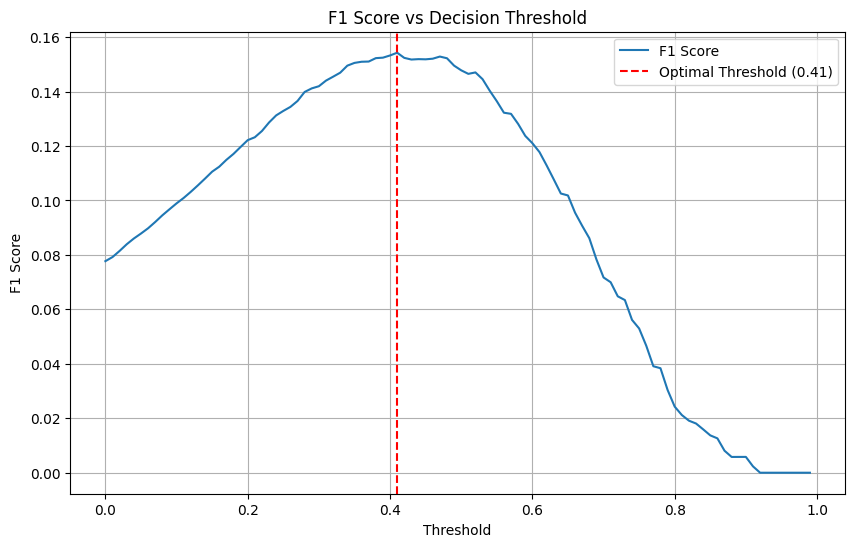

In [8]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score

print("Generating cross-validated predictions...")
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    y_scores = cross_val_predict(stacking_clf, X_train, y_train, cv=5, method='predict_proba')[:, 1]

thresholds = np.arange(0.0, 1.0, 0.01)
f1_scores = []

for thresh in thresholds:
    y_pred_thresh = (y_scores >= thresh).astype(int)
    f1_scores.append(f1_score(y_train, y_pred_thresh))

optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
max_f1_score = f1_scores[optimal_idx]

print(f"Optimal Threshold: {optimal_threshold:.2f}")
print(f"Max Cross-Validated F1 Score: {max_f1_score:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.axvline(optimal_threshold, color='r', linestyle='--', label=f'Optimal Threshold ({optimal_threshold:.2f})')
plt.title('F1 Score vs Decision Threshold')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()

## 7. Final Evaluation on Test Set

Now we perform the final "exam". We will:
1.  Retrain the Stacking Model on the **full training set**.
2.  Predict probabilities on the **held-out test set**.
3.  Apply our **Optimal Threshold** to generate final class predictions.
4.  Report the final performance metrics.

Retraining Stacking Model on full training set...

--- Final Test Set Performance ---
ROC-AUC: 0.7093

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.84      0.90     10176
           1       0.10      0.42      0.16       436

    accuracy                           0.82     10612
   macro avg       0.54      0.63      0.53     10612
weighted avg       0.94      0.82      0.87     10612


--- Final Test Set Performance ---
ROC-AUC: 0.7093

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.84      0.90     10176
           1       0.10      0.42      0.16       436

    accuracy                           0.82     10612
   macro avg       0.54      0.63      0.53     10612
weighted avg       0.94      0.82      0.87     10612



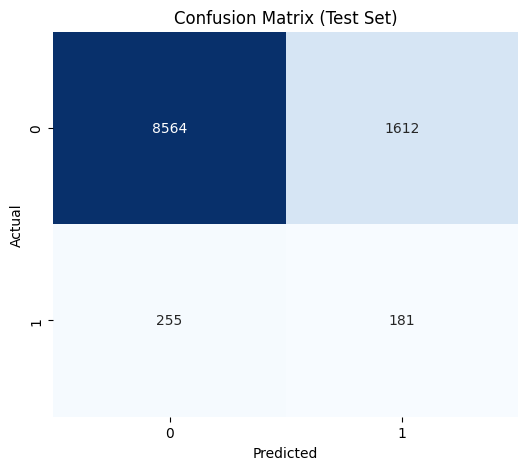

In [9]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

print("Retraining Stacking Model on full training set...")
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    stacking_clf.fit(X_train, y_train)

print("\n--- Final Test Set Performance ---")

# Handle Hard Voting (no predict_proba)
if hasattr(stacking_clf, 'predict_proba'):
    y_test_probs = stacking_clf.predict_proba(X_test)[:, 1]
    y_test_pred = (y_test_probs >= optimal_threshold).astype(int)
    print(f"ROC-AUC: {roc_auc_score(y_test, y_test_probs):.4f}")
else:
    print("Hard Voting detected: Skipping ROC-AUC and Thresholding.")
    y_test_pred = stacking_clf.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## 8. Generate Submission File

We will now generate predictions for the **Test Dataset** (`data/test.parquet`).
Since this is likely raw data, we need to apply the same **Feature Engineering** steps as we did for the training data.

**Steps**:
1.  Load `test.parquet`.
2.  Apply `extract_user_attributes` and `aggregate_user_features`.
3.  Generate probabilities using the trained `stacking_clf`.
4.  Apply the `optimal_threshold`.
5.  Save to `submission.csv`.

In [10]:
import importlib
import src.features
importlib.reload(src.features)
from src.features import extract_user_attributes, aggregate_user_features

# 1. Load Raw Test Data
test_data_path = '../data/test.parquet'
print(f"Loading test data from {test_data_path}...")
test_df_raw = pd.read_parquet(test_data_path)

# 2. Apply Feature Engineering
print("Applying feature engineering...")
test_df_raw = extract_user_attributes(test_df_raw)

# --- CRITICAL FIX FOR TEST SET ---
# The test set is a snapshot of the "current" state.
# We must calculate features relative to the END of the test period (Global Max Timestamp),
# NOT relative to each user's last event.
# If we use user's last event (default), 'days_since_last_session' would be 0 for everyone,
# destroying the most important churn signal (inactivity).

global_max_ts = test_df_raw['ts'].max()
print(f"Global Test Cutoff Timestamp: {global_max_ts}")

# Create a snapshot dataframe for test users
test_snapshot_df = pd.DataFrame({
    'userId': test_df_raw['userId'].unique(),
    'cutoff_ts': global_max_ts
})

# Generate features using this common cutoff
test_features = aggregate_user_features(test_df_raw, snapshot_df=test_snapshot_df)

# The result has a MultiIndex (userId, cutoff_ts), we drop the cutoff_ts level
test_features = test_features.reset_index(level='cutoff_ts', drop=True)

# --- FEATURE ENGINEERING BOOST (Must match Training) ---
if 'sessions_last_7d' in test_features.columns and 'sessions_last_28d' in test_features.columns:
    test_features['session_velocity'] = test_features['sessions_last_7d'] / (test_features['sessions_last_28d'] / 4 + 0.01)

if 'days_since_last_session' in test_features.columns and 'total_sessions' in test_features.columns:
    test_features['recency_frequency_ratio'] = test_features['days_since_last_session'] / (test_features['total_sessions'] + 1)
# -----------------------------------------------------

# Drop 'target' if it exists
if 'target' in test_features.columns:
    test_features = test_features.drop(columns=['target'])

# Ensure columns match training data
missing_cols = set(X_train.columns) - set(test_features.columns)
for c in missing_cols:
    test_features[c] = 0

# Reorder columns to match X_train
test_features = test_features[X_train.columns]

print(f"Test Features Shape: {test_features.shape}")
print(f"Avg Days Since Last Session: {test_features['days_since_last_session'].mean():.2f} days")

# 3. Generate Predictions
print("Generating predictions...")

if hasattr(stacking_clf, 'predict_proba'):
    test_probs = stacking_clf.predict_proba(test_features)[:, 1]
    test_preds = (test_probs >= optimal_threshold).astype(int)
else:
    print("Hard Voting detected: Using direct class predictions.")
    test_preds = stacking_clf.predict(test_features)

# 4. Create Submission DataFrame
submission_df = pd.DataFrame({
    'id': test_features.index,
    'target': test_preds
})

# 5. Save to CSV
submission_path = '../data/submission.csv'
submission_df.to_csv(submission_path, index=False)

print(f"Submission saved to {submission_path}")
print(submission_df.head())

Loading test data from ../data/test.parquet...
Applying feature engineering...
Applying feature engineering...
Global Test Cutoff Timestamp: 2018-11-20 00:00:00
Global Test Cutoff Timestamp: 2018-11-20 00:00:00
Test Features Shape: (2904, 49)
Avg Days Since Last Session: 5.14 days
Generating predictions...
Submission saved to ../data/submission.csv
        id  target
0  1000655       0
1  1000963       1
2  1001129       0
3  1001963       1
4  1002283       1
Test Features Shape: (2904, 49)
Avg Days Since Last Session: 5.14 days
Generating predictions...
Submission saved to ../data/submission.csv
        id  target
0  1000655       0
1  1000963       1
2  1001129       0
3  1001963       1
4  1002283       1


In [11]:
import time

current_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
message = f"Raynor's attempt at {current_time}"

In [12]:
! ../../.venv/bin/kaggle competitions submit -c churn-prediction-25-26 -f ../data/submission.csv -m "{message}"

100%|██████████████████████████████████████| 28.4k/28.4k [00:00<00:00, 73.6kB/s]
100%|██████████████████████████████████████| 28.4k/28.4k [00:00<00:00, 73.6kB/s]
Successfully submitted to Churn prediction 25/26Successfully submitted to Churn prediction 25/26

In [13]:
# --- SAVE MODEL ARTIFACTS ---
import joblib
import os

# Create models directory if it doesn't exist
models_dir = "../models"
os.makedirs(models_dir, exist_ok=True)

print(f"Saving artifacts to {models_dir}...")

# 1. Save the Stacking Model
model_path = os.path.join(models_dir, "stacking_model.joblib")
joblib.dump(stacking_clf, model_path)
print(f"- Model saved to {model_path}")

# 2. Save the Preprocessor
preprocessor_path = os.path.join(models_dir, "preprocessor.joblib")
joblib.dump(preprocessor, preprocessor_path)
print(f"- Preprocessor saved to {preprocessor_path}")

# 3. Save the Optimal Threshold
threshold_path = os.path.join(models_dir, "optimal_threshold.joblib")
joblib.dump(optimal_threshold, threshold_path)
print(f"- Optimal Threshold ({optimal_threshold:.4f}) saved to {threshold_path}")

# 4. Save Feature Names (Crucial for alignment)
features_path = os.path.join(models_dir, "feature_names.joblib")
joblib.dump(X_train.columns, features_path)
print(f"- Feature names saved to {features_path}")

Saving artifacts to ../models...
- Model saved to ../models/stacking_model.joblib
- Preprocessor saved to ../models/preprocessor.joblib
- Optimal Threshold (0.4100) saved to ../models/optimal_threshold.joblib
- Feature names saved to ../models/feature_names.joblib
- Model saved to ../models/stacking_model.joblib
- Preprocessor saved to ../models/preprocessor.joblib
- Optimal Threshold (0.4100) saved to ../models/optimal_threshold.joblib
- Feature names saved to ../models/feature_names.joblib


In [14]:
import json
import time

print("--- AUTOMATED REPORT FOR AI AGENT ---")
print(f"Date: {time.strftime('%Y-%m-%d %H:%M:%S')}")

# Gather info
report = {
    "configuration": {
        "N_SNAPSHOTS": N_SNAPSHOTS,
        "CHURN_WINDOW_DAYS": CHURN_WINDOW_DAYS,
        "SNAPSHOT_INTERVAL_DAYS": SNAPSHOT_INTERVAL_DAYS,
        "scale_pos_weight": round(scale_pos_weight, 2)
    },
    "data_shape": X_train.shape,
    "features": list(X_train.columns),
    "model_performance_cv": {
        "f1_mean": cv_results_stack['test_f1'].mean(),
        "f1_std": cv_results_stack['test_f1'].std(),
        #"roc_auc_mean": cv_results_stack['test_roc_auc'].mean(),
        "accuracy_mean": cv_results_stack['test_accuracy'].mean()
    },
    "optimization": {
        "optimal_threshold": optimal_threshold,
        "max_f1_at_threshold": max_f1_score
    }
}

print(json.dumps(report, indent=2, default=str))
print("-------------------------------------")
print("Copy the JSON above and paste it to the AI Agent for analysis.")

--- AUTOMATED REPORT FOR AI AGENT ---
Date: 2025-12-04 00:23:27
{
  "configuration": {
    "N_SNAPSHOTS": 3,
    "CHURN_WINDOW_DAYS": 10,
    "SNAPSHOT_INTERVAL_DAYS": 14,
    "scale_pos_weight": 23.74
  },
  "data_shape": [
    42330,
    49
  ],
  "features": [
    "gender",
    "level",
    "platform",
    "is_thumbs_up",
    "is_thumbs_down",
    "is_ad",
    "is_song",
    "length",
    "songs_last_1d",
    "listen_time_last_1d",
    "unique_artists_last_1d",
    "songs_last_3d",
    "thumbs_down_last_3d",
    "listen_time_last_3d",
    "unique_artists_last_3d",
    "songs_last_7d",
    "thumbs_down_last_7d",
    "listen_time_last_7d",
    "unique_artists_last_7d",
    "unique_songs_last_7d",
    "songs_last_14d",
    "thumbs_down_last_14d",
    "listen_time_last_14d",
    "unique_artists_last_14d",
    "unique_songs_last_14d",
    "songs_last_30d",
    "thumbs_down_last_30d",
    "listen_time_last_30d",
    "unique_artists_last_30d",
    "unique_songs_last_30d",
    "account_life